<a href="https://colab.research.google.com/github/rickyhndrwn/tubes_tkc-18_247-18_249/blob/main/Tugas%20-%209%20-%20Progress%20Herokus/tugas_9_progres_heroku.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Tugas 9 - Progres Heroku
---
Temu Kembali Citra 7B 2021

Anggota:
* 201810370311247 - Ricky Hendrawan
* 201810370311249 - Shofiyah

## Import library

In [10]:
from tensorflow.keras import preprocessing
from tensorflow.keras.applications.densenet import DenseNet121, DenseNet169, DenseNet201, preprocess_input
from tensorflow.keras.models import Model
from keras.models import load_model
from random import choice, shuffle
from pathlib import Path
from PIL import Image
import numpy as np
import os

import matplotlib.pyplot as plt

In [ ]:
target_dir = '/content/drive/MyDrive/Informatika/Semester 7/Temu Kembali Citra/CBIR Normal Pneumonia'

## Instantiate model

In [2]:
base_model = DenseNet121()
model_dn121 = Model(inputs=base_model.input,
              outputs=base_model.get_layer('predictions').output)

# model_dn121.save(target_dir + '/cxr_densenet121.h5')

base_model = DenseNet169()
model_dn169 = Model(inputs=base_model.input,
              outputs=base_model.get_layer('predictions').output)

# model_dn169.save(target_dir + '/cxr_densenet169.h5')

base_model = DenseNet201()
model_dn201 = Model(inputs=base_model.input,
              outputs=base_model.get_layer('predictions').output)

# model_dn201.save(target_dir + '/cxr_densenet201.h5')

82534400/82524592 [==============================] - 1s 0us/step


## Feature extractor class

In [3]:
class FeatureExtractor:
    def __init__(self, model):
        self.model = model
    
    def extract(self, img):
        img = img.convert('RGB')
        
        x = preprocessing.image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = preprocess_input(x)
        
        feature = self.model.predict(x)[0]
        
        return feature / np.linalg.norm(feature)

fe_dn121 = FeatureExtractor(model_dn121)
fe_dn169 = FeatureExtractor(model_dn169)
fe_dn201 = FeatureExtractor(model_dn201)

## Extract features

In [7]:
img_db_dir = '/content/drive/MyDrive/Dataset/chest_xray/resized_image3000(224x224)'
feature_save_dir = '/content/drive/MyDrive/Informatika/Semester 7/Temu Kembali Citra/CBIR Normal Pneumonia'

img_paths = list()
features_dn121 = list()
features_dn169 = list()
features_dn201 = list()

for img_path in sorted(Path(img_db_dir).glob("*.jpeg")):
    img_paths.append(img_path)

    feature_dn121 = fe_dn121.extract(img=Image.open(img_path))
    features_dn121.append(feature_dn121)

    feature_dn169 = fe_dn169.extract(img=Image.open(img_path))
    features_dn169.append(feature_dn169)

    feature_dn201 = fe_dn201.extract(img=Image.open(img_path))
    features_dn201.append(feature_dn201)

feature_dn121 = np.array(feature_dn121)
np.save(feature_save_dir + '/features_densenet121.npy', feature_dn121)

feature_dn169 = np.array(feature_dn169)
np.save(feature_save_dir + '/features_densenet169.npy', feature_dn169)

feature_dn201 = np.array(feature_dn201)
np.save(feature_save_dir + '/features_densenet201.npy', feature_dn201)

features_dn121 = np.load(feature_save_dir + '/features_densenet121.npy')
features_dn169 = np.load(feature_save_dir + '/features_densenet169.npy')
features_dn201 = np.load(feature_save_dir + '/features_densenet201.npy')

print(f"Jumlah citra database: {len(img_paths)}")

Jumlah citra database: 3000


## Load test images

In [8]:
test_dir = '/content/drive/MyDrive/Dataset/chest_xray/resized_test_image160(224x224)'

test_img_paths = list()
for img_path in sorted(Path(test_dir).glob("*.jpeg")):
    test_img_paths.append(img_path)

print(f"Jumlah citra uji: {len(test_img_paths)}")

Jumlah citra uji: 160


## Average precision eval

In [17]:
def find_y_pred(scores):
    y_pred = list()
    for score in scores:
        db_img_name = os.path.basename(score[1])
        y_pred.append(db_img_name[0])
    
    return np.array(y_pred, dtype=int)


def image_retrieval_func(query_image, n_img, model):
    img = Image.open(query_image)

    query = model.extract(img)
    dists = np.linalg.norm(features_dn201 - query, axis=1)

    # Extract n_img images that have lowest distance
    ids = np.argsort(dists)[:n_img]
    scores = [(dists[id], img_paths[id]) for id in ids]

    query_img_name = os.path.basename(query_image)
    query_img_class = query_img_name[0]
    
    y_true = np.array([query_img_class for _ in range(n_img)], dtype=int)
    y_pred = find_y_pred(scores)

    return y_true, y_pred


def calc_precision(test_img_path, n_img, model):
    y_true, y_pred = image_retrieval_func(test_img_path, n_img, model)
    relevant_img = np.sum(y_true == y_pred)
    precision = relevant_img / float(n_img)

    return round(precision, 3)

In [12]:
norm_test_img_paths = test_img_paths[:80]
pneu_test_img_paths = test_img_paths[80:160]

### Normal class
---
Kumpulkan rata-rata presisi menggunakan ketiga versi DenseNet dengan data uji. Jumlah fetch data (retrieved image) diatur ke angka 10 sampai 100 dengan kelipatan 10 (10, 20, ..., 100)

In [18]:
# kumpulan presisi kelas normal dari densenet121
norm_dn121_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in norm_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn121)
        precision_list.append(p)
    norm_dn121_precision_list.append(np.mean(precision_list))

# kumpulan presisi kelas normal dari densenet169
norm_dn169_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in norm_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn169)
        precision_list.append(p)
    norm_dn169_precision_list.append(np.mean(precision_list))

# kumpulan presisi kelas normal dari densenet201
norm_dn201_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in norm_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn201)
        precision_list.append(p)
    norm_dn201_precision_list.append(np.mean(precision_list))

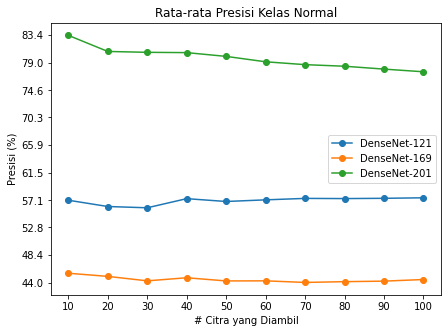

In [19]:
highest_value = max(max(norm_dn121_precision_list), max(norm_dn169_precision_list), max(norm_dn201_precision_list))
lowest_value = min(min(norm_dn121_precision_list), min(norm_dn169_precision_list), min(norm_dn201_precision_list))

x_tick_values = range(10, 110, 10)
y_tick_values = 100 * np.round(np.linspace(lowest_value, highest_value, 10), 3)

plt.figure(figsize=(7,5))

plt.plot(x_tick_values, 100 * np.array(norm_dn121_precision_list), marker='o')
plt.plot(x_tick_values, 100 * np.array(norm_dn169_precision_list), marker='o')
plt.plot(x_tick_values, 100 * np.array(norm_dn201_precision_list), marker='o')

plt.xticks(x_tick_values)
plt.yticks(y_tick_values)

plt.xlabel("# Citra yang Diambil")
plt.ylabel("Presisi (%)")

plt.legend(['DenseNet-121', 'DenseNet-169', 'DenseNet-201'])
plt.title("Rata-rata Presisi Kelas Normal")
plt.show()

### Pneumonia class
---
Kumpulkan rata-rata presisi menggunakan ketiga versi DenseNet dengan data uji. Jumlah fetch data (retrieved image) diatur ke angka 10 sampai 100 dengan kelipatan 10 (10, 20, ..., 100)

In [20]:
# kumpulan presisi kelas pneumonia dari densenet121
pneu_dn121_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in pneu_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn121)
        precision_list.append(p)
    pneu_dn121_precision_list.append(np.mean(precision_list))

# kumpulan presisi kelas pneumonia dari densenet169
pneu_dn169_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in pneu_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn169)
        precision_list.append(p)
    pneu_dn169_precision_list.append(np.mean(precision_list))

# kumpulan presisi kelas pneumonia dari densenet201
pneu_dn201_precision_list = list()
for n_img in range(10,110,10):
    precision_list = list()
    for img_dir in pneu_test_img_paths:
        p = calc_precision(img_dir, n_img, fe_dn201)
        precision_list.append(p)
    pneu_dn201_precision_list.append(np.mean(precision_list))

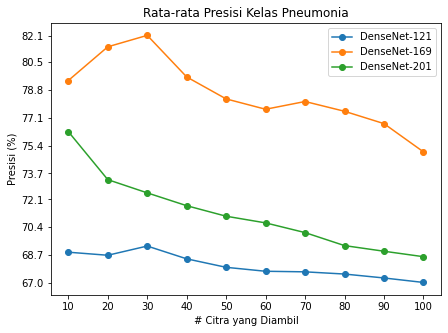

In [21]:
highest_value = max(max(pneu_dn121_precision_list), max(pneu_dn169_precision_list), max(pneu_dn201_precision_list))
lowest_value = min(min(pneu_dn121_precision_list), min(pneu_dn169_precision_list), min(pneu_dn201_precision_list))

x_tick_values = range(10, 110, 10)
y_tick_values = 100 * np.round(np.linspace(lowest_value, highest_value, 10), 3)

plt.figure(figsize=(7,5))

plt.plot(x_tick_values, 100 * np.array(pneu_dn121_precision_list), marker='o')
plt.plot(x_tick_values, 100 * np.array(pneu_dn169_precision_list), marker='o')
plt.plot(x_tick_values, 100 * np.array(pneu_dn201_precision_list), marker='o')

plt.xticks(x_tick_values)
plt.yticks(y_tick_values)

plt.xlabel("# Citra yang Diambil")
plt.ylabel("Presisi (%)")

plt.legend(['DenseNet-121', 'DenseNet-169', 'DenseNet-201'])
plt.title("Rata-rata Presisi Kelas Pneumonia")
plt.show()